#Transfer Learning with TensorFlow Part 2: Fine Tuning

In the previous notebook we covered transfer learning feature extraction, now its time to learn new kind of transfer learning fine tuning

In [ ]:
#Check if we're using a GPU
!nvidia-smi

Sat Aug 12 10:02:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Creating a help function

In the previous notebook, we've created a bunch of helper function, wecouldd rewrite them but its tedious.

So, it's a good idea to put functions you'll want to use in a sscript you can download and import into your notebook or else where

We've done that for the functions we've used previously:
https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-12 10:02:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-12 10:02:18 (93.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
#Import heplfer function
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

**Note:** If you're running this notebook in Google Colab, when it time out Colab will delete 'helper_functions.py' so, you'll re-download this cells

##Let's get some data

This time we're goint ot see how we can use the pretrained model withintf.keras.applications and apply them to our own problem



In [ ]:
#Get 10?% of trianing data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")


--2023-08-12 10:02:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 172.253.118.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.5MB/s    in 8.3s    

2023-08-12 10:02:32 (19.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
#Check out how many images and subdirectories contained in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/gri

In [ ]:
#Creating training and test directory paths
train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
Img_size=(224,224)
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                         image_size=Img_size,
                                                                         label_mode="categorical",
                                                                         batch_size=32)
test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                              image_size=Img_size,
                                                              label_mode="categorical",
                                                              batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
#Check out the class name of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
#See an example of a batch of data
for images,labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[3.80000000e+01 0.00000000e+00 0.00000000e+00]
   [3.80000000e+01 0.00000000e+00 0.00000000e+00]
   [3.65714264e+01 0.00000000e+00 0.00000000e+00]
   ...
   [1.20734795e+02 1.04576653e+02 9.42960358e+01]
   [1.24954109e+02 1.11311256e+02 1.02311256e+02]
   [1.31801147e+02 1.17515434e+02 1.10158287e+02]]

  [[3.80000000e+01 0.00000000e+00 0.00000000e+00]
   [3.80000000e+01 0.00000000e+00 0.00000000e+00]
   [3.65714264e+01 0.00000000e+00 0.00000000e+00]
   ...
   [8.01837616e+01 6.02704926e+01 5.28266602e+01]
   [7.92193832e+01 5.94336700e+01 5.23622398e+01]
   [8.59746552e+01 6.52603683e+01 6.01175156e+01]]

  [[3.80000000e+01 0.00000000e+00 0.00000000e+00]
   [3.80000000e+01 0.00000000e+00 0.00000000e+00]
   [3.65714264e+01 0.00000000e+00 0.00000000e+00]
   ...
   [5.09030342e+01 2.24744606e+01 1.89030342e+01]
   [4.70714264e+01 1.86428566e+01 1.58571415e+01]
   [5.17654152e+01 2.31225567e+01 2.03368416e+01]]

  ...

  [[3.44387589e+01 1.28061998e+00 0.00000000e+00]
   [3

##model 0:Building a tranfer learning using Keras Functional API

The sequential API is straight-forward it runs our layers in a sequential order.

But the functional API gives us more flexibilty with our model

In [ ]:
#1. Create Baseline model with tf.keras.applications
base_model=tf.keras.applications.EfficientNetB0(include_top=False)

#2. Freeze the base model (so the underlying pre-trained patterns aren't updated)
base_model.trainable=False

#3. Create input into our model
inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

#4. If using models like ResNet50V2 you will need to normmalize inputs
#x=tf.keras.layers.experimnetal.preprocessing.Rescaling(1/255.)(inputs)

#5. Pass the inputs to the base_model
x=base_model(inputs)
print(f"Shape after passing through inputs base model: {x.shape}")

#6. Average pool the outputs of the base model(aggregrate all the important information, reduce number of computaitions)
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after pooling:{x.shape}")

#7. Create the output activation layer
outputs=tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

#8 .Combine the inputs and outputs in a model
model_0=tf.keras.Model(inputs,outputs)

#9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#10. Fit the model
history_0=model_0.fit(train_data_10_percent,
                      epochs=5,
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=test_data,
                      validation_steps=int(0.25*len(test_data)),
                      callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                             experiment_name="10_percent")])

16705208/16705208 [==============================] - 2s 0us/step


Shape after passing through inputs base model: (None, 7, 7, 1280)
Shape after pooling:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent/20230812-100249
Epoch 1/5
24/24 [==============================] - 25s 354ms/step - loss: 1.8995 - accuracy: 0.4067 - val_loss: 1.3429 - val_accuracy: 0.7549
Epoch 2/5
24/24 [==============================] - 6s 215ms/step - loss: 1.1081 - accuracy: 0.7773 - val_loss: 0.8959 - val_accuracy: 0.8092
Epoch 3/5
24/24 [==============================] - 7s 288ms/step - loss: 0.7927 - accuracy: 0.8160 - val_loss: 0.7152 - val_accuracy: 0.8487
Epoch 4/5
24/24 [==============================] - 5s 188ms/step - loss: 0.6452 - accuracy: 0.8453 - val_loss: 0.6422 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 7s 294ms/step - loss: 0.5455 - accuracy: 0.8827 - val_loss: 0.5814 - val_accuracy: 0.8520


In [ ]:
#Evaluate on full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 10s 123ms/step - loss: 0.5651 - accuracy: 0.8580


[0.5651085376739502, 0.8579999804496765]

In [ ]:
#Check the alyerin in our basse model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name)


0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [ ]:
#How about we get asummary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
#How about summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


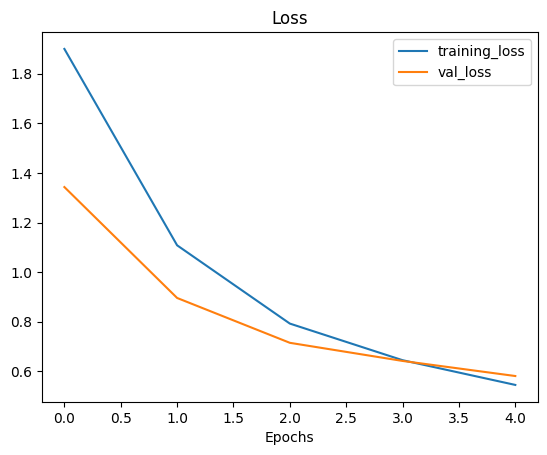

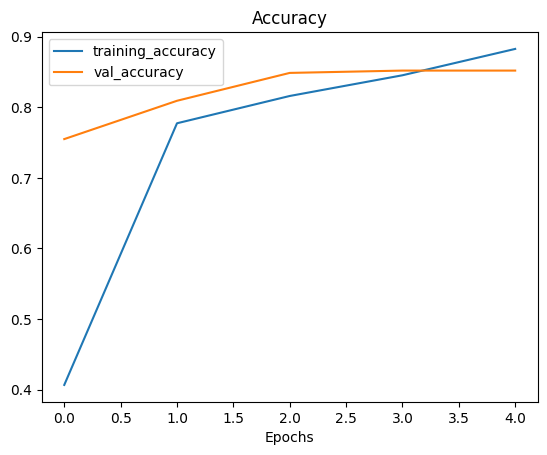

In [ ]:
#Check out our loss curves
plot_loss_curves(history_0)

##Getting a feature vector from a trained model

Let's deonstrate the Global Average Pooling Layer

We have a tensor after our model goes through 'base_model' of shape(None,7,7,1280)...

But then when it passes through Global Average Pooling 2d it turns into (None,1280)

Let's use  similar shaped tensor of(1,4,4,) and then pass it through GlobalAveragePooling2D





In [ ]:
#Define the input shape
input_shape=(1,4,4,3)

#Create a random tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)
print(f"Random input tensor:\n{input_tensor}")

#Pass the random tensor through a global average pooling 2d layer
global_average_pooled_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n{global_average_pooled_tensor}")

#Check the shape of the different tensors
print(f"Shape of the input tensor:{input_tensor.shape}")
print(f"Shape of gloabl average pool:{global_average_pooled_tensor.shape}")

Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
2D global average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]
Shape of the input tensor:(1, 4, 4, 3)
Shape of gloabl average pool:(1, 3)


In [ ]:
#Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

##Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of training data, but how does it go with 1% of training data....How about we set up bunch of experiments ot find out

1. 'model_1' - use feature extraction transfer learning with 1% of training data with data augmentation
2. 'model_2' - use feature extracction transfer learning with 10% of training data with data augmentation
3. 'model_3' - use fine-tuning transfer learning on 10% of training data with data augmentation.
4. 'model_4' - use fine-tuning with 100% of training data with data augmentation

**Note:**throughout all experiments same dataset is used.

##Getting and preprocessing data for model_1

In [ ]:
#Download and unzip data - preprocessed from food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-08-12 10:04:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  20.7MB/s    in 8.7s    

2023-08-12 10:04:09 (14.6 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
#Create training and test dirs
train_dir_1_percent="10_food_classes_1_percent/train"
test_dir="10_food_classes_1_percent/test"

In [ ]:
#How many images we're working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'

In [ ]:
#Setup data loader
Img_size=(224,224)
train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                         label_mode="categorical",
                                                                         image_size=Img_size,
                                                                         batch_size=32)
test_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                         label_mode="categorical",
                                                                         image_size=Img_size,
                                                                         batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


##Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:
* 'tf.keras.layers.experimental.preprocessing()'

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Create data augmentation stage with horizontal flipping, rotations, zooms etc.
data_augmentation=keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    #preprocessing.Rescale(1./255),
],name="data_augmentation")

###Visualize our data augmentation layer


Text(0.5, 1.0, 'Augmented random image from class: chicken_curry')

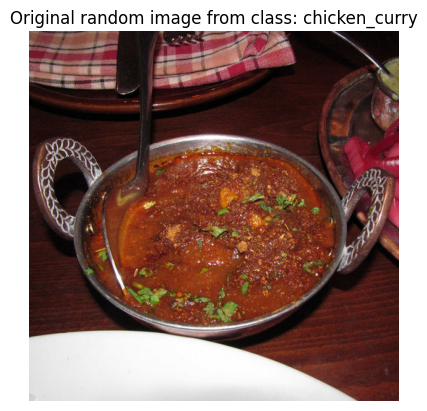

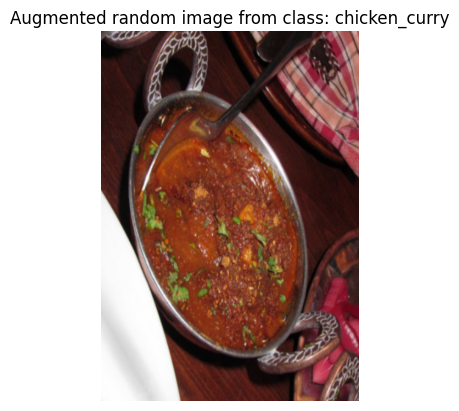

In [ ]:
#View a random image and comapre it to its augmented image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class=random.choice(train_data_1_percent.class_names)
target_dir="10_food_classes_1_percent/train/"+target_class
random_image=random.choice(os.listdir(target_dir))
random_image_path=target_dir+"/"+random_image

#Read in the random image
img=mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

#Now let's plot our augmented rrandom image
augmented_img=data_augmentation(img)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.axis(False)
plt.title(f"Augmented random image from class: {target_class}")

##Model 1:Feature extraction transfer learning on 1% of the data with data augmentation


In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230812-100415
Epoch 1/5
3/3 [==============================] - 13s 3s/step - loss: 2.4697 - accuracy: 0.0857 - val_loss: 2.2906 - val_accuracy: 0.1135
Epoch 2/5
3/3 [==============================] - 4s 1s/step - loss: 2.2047 - accuracy: 0.1571 - val_loss: 2.1660 - val_accuracy: 0.2072
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9648 - accuracy: 0.3857 - val_loss: 2.0229 - val_accuracy: 0.3191
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.7816 - accuracy: 0.5286 - val_loss: 1.9075 - val_accuracy: 0.4062
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6248 - accuracy: 0.5857 - val_loss: 1.8169 - val_accuracy: 0.4704


In [ ]:
#Check out the model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
#Evaluate the model
results_1=model_1.evaluate(test_data)

79/79 [==============================] - 7s 86ms/step - loss: 1.8228 - accuracy: 0.4616


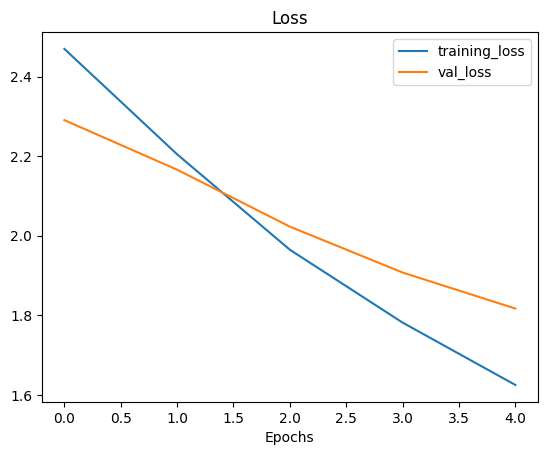

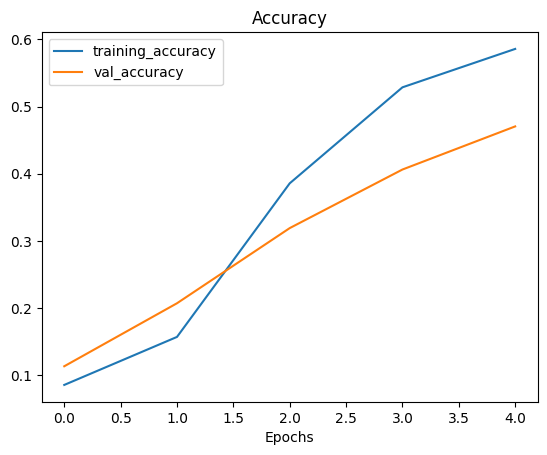

In [ ]:
#How does the model go with data augmentation loss curves look like?
plot_loss_curves(history_1_percent)

##Model 2: Feature extraction transfer learning model with 10% data and data augmentation

In [ ]:
#Get 10% of data
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
#unzip_data(10_food_classes_10_percent)

train_dir_10_percent="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [ ]:
#Set data inputs
import tensorflow as tf
Img_size=(224,224)
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                          label_mode="categorical",
                                                                          image_size=Img_size)
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode="categorical",
                                                              image_size=Img_size)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
#Ceate model 2 with data augmentation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#Build data augmentation layer
data_augmentation=Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    #preprocessing.Rescale(1./255),
],name="data_augmentation")

#Set up the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])


###Creating a ModelCheckpoint callback
  
The ModelCheckpoint callback intermediately saves our model (full model or just the weights) during training. THis is useful so we can come and start where we left of

In [ ]:
#Set checkpoint path
checkpoint_path="tens_perrcent_model_checkpoints_weights/checkpoint.ckpt"

#Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_weights_only=True,
                                                       save_best_only=False,
                                                       save_freq="epoch",
                                                       verbose=1)

###Fit the model passing in the ModelCheeckpoint callbacks

In [ ]:
#Fit the model saving checkpoints every epoch
initial_epochs=5
history_2=model_2.fit(train_data_10_percent,
                      epochs=initial_epochs,
                      validation_data=test_data,
                      validation_steps=int(0.25*len(test_data)),
                      callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                              experiment_name="10_percent_data_aug"),
                                 checkpoint_callback]
                      )

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230812-100501
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9387 - accuracy: 0.3613
Epoch 1: saving model to tens_perrcent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 24s 668ms/step - loss: 1.9387 - accuracy: 0.3613 - val_loss: 1.4440 - val_accuracy: 0.6497
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2857 - accuracy: 0.7027
Epoch 2: saving model to tens_perrcent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 572ms/step - loss: 1.2857 - accuracy: 0.7027 - val_loss: 1.0239 - val_accuracy: 0.7615
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9898 - accuracy: 0.7653
Epoch 3: saving model to tens_perrcent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 547ms/step - loss: 0.9898 - accuracy: 0.7653 - val_loss: 0.8009 - val_accuracy: 0.

In [ ]:
results_10_percent_data_aug=model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.6316 - accuracy: 0.8408


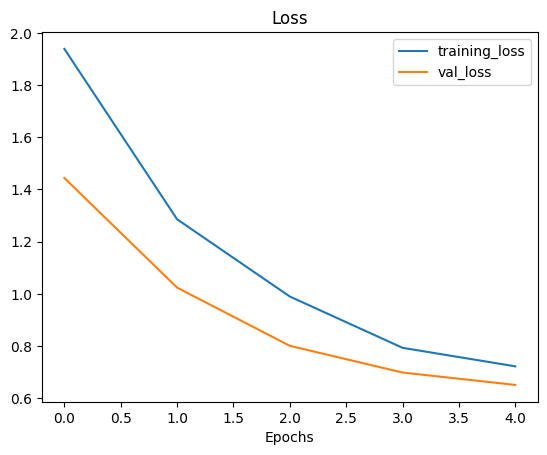

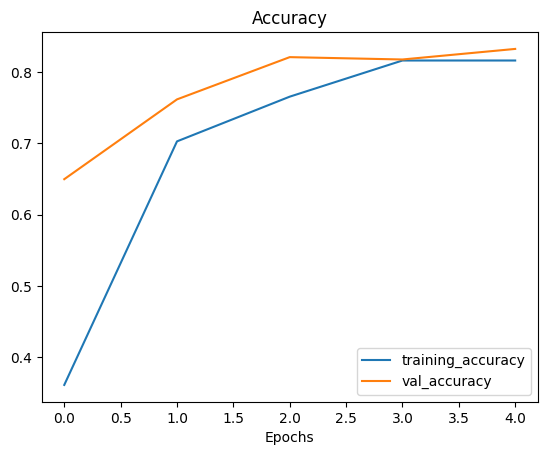

In [ ]:
#Plot model loss curves
plot_loss_curves(history_2)

###Loading in checkpoint weights

Loading in checkpointed weights returns a model to a specific checkpoint


In [ ]:
#Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
#Evaluate model_2 with loaded weights
loaded_weights_model_results=model_2.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 0.6316 - accuracy: 0.8408


In [ ]:
#If the resulta from our previously evaluated model_2 match the loaded weights, eveything as worked
results_10_percent_data_aug==loaded_weights_model_results

True

##Model 3: Fine-tuning an existing model onn 10% of data

**Note**:Fine-tuning usually works beat after training a feature extraction model for a few epochs with large amounts of data



In [ ]:
#Layers in loaded model
model_2.layers

In [ ]:
#Are these layers trainable
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7e3720796ef0> True
<keras.engine.sequential.Sequential object at 0x7e367d464970> True
<keras.engine.functional.Functional object at 0x7e367caa4a60> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7e367c9c1750> True
<keras.layers.core.dense.Dense object at 0x7e367ca42650> True


In [ ]:
#What layers are in our base model
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
#How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
#To begin fine-tuning, let's start by setting the last 10 layers of our base model.trainable=True
base_model.trainable=True

#Freeze all layers expect last 10
for layer in base_model.layers[:-10]:
  layer.trainable=False

#Recompile  (we have to recompile everytime we make a change in our model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

**Note**: When using fine-tuning it's best to practice to lower your learning rate by some amount. How much? This ia hyperparameter you can tune. But it is good to lower it by 10x

In [ ]:
#Check which layers are tunable
for layer_number,layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
#Now we've unfrozen some if the layers closer to the top, how many trainavle variables are there?
print(len(model_2.trainable_variables))

12


In [ ]:
#Fine tune for another 5 epochs
fine_tune_epochs=initial_epochs+5

#Refit the model(same as model_2)
history_fine=model_2.fit(train_data_10_percent,
                         epochs=fine_tune_epochs,
                         validation_data=test_data,
                         validation_steps=int(0.25*len(test_data)),
                         initial_epoch=history_2.epoch[-1],
                         callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230812-100641
Epoch 5/10
24/24 [==============================] - 24s 553ms/step - loss: 0.6379 - accuracy: 0.8200 - val_loss: 0.5288 - val_accuracy: 0.8355
Epoch 6/10
24/24 [==============================] - 11s 447ms/step - loss: 0.4914 - accuracy: 0.8547 - val_loss: 0.4910 - val_accuracy: 0.8438
Epoch 7/10
24/24 [==============================] - 11s 427ms/step - loss: 0.4241 - accuracy: 0.8787 - val_loss: 0.4949 - val_accuracy: 0.8421
Epoch 8/10
24/24 [==============================] - 10s 380ms/step - loss: 0.3864 - accuracy: 0.8720 - val_loss: 0.4963 - val_accuracy: 0.8355
Epoch 9/10
24/24 [==============================] - 9s 358ms/step - loss: 0.3425 - accuracy: 0.9107 - val_loss: 0.4809 - val_accuracy: 0.8421
Epoch 10/10
24/24 [==============================] - 9s 347ms/step - loss: 0.3083 - accuracy: 0.9053 - val_loss: 0.4346 - val_accuracy: 0.8635


In [ ]:
#Evaluate the fine-tuned model(model_3 ehich is actually model_2 fine tune)
results_fine_tuned=model_2.evaluate(test_data)

79/79 [==============================] - 8s 91ms/step - loss: 0.4375 - accuracy: 0.8564


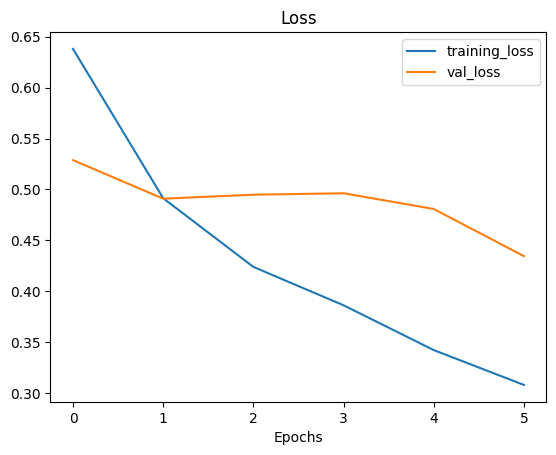

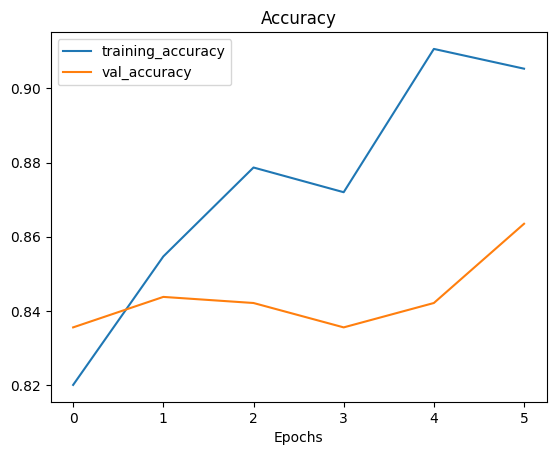

In [ ]:
#Check out loss curves of our fine tuned model
plot_loss_curves(history_fine)

The 'plot_loss_curves' function works grate with  model which have only been fit once, however, we want something to compare one series of running 'fit()' with another

In [ ]:
#Let's craete a function to compare training histories
def compare_histories(original_history,new_history,initial_epochs=5):
  """
  Compare two tensorflow history objects
  """
  #Get original history measurements
  acc=original_history.history["accuracy"]
  loss=original_history.history["loss"]

  val_acc=original_history.history["val_accuracy"]
  val_loss=original_history.history["val_loss"]

  #Combine original history
  total_acc=acc+new_history.history["accuracy"]
  total_loss=loss+new_history.history["loss"]

  total_val_acc=val_acc+new_history.history["val_accuracy"]
  total_val_loss=val_loss+new_history.history["val_loss"]

  #Make plots for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc,label="Training Accuracy")
  plt.plot(total_val_acc,label="Validation Accuracy")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  #Make plots for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_loss,label="Training Loss")
  plt.plot(total_val_loss,label="Validation Loss")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

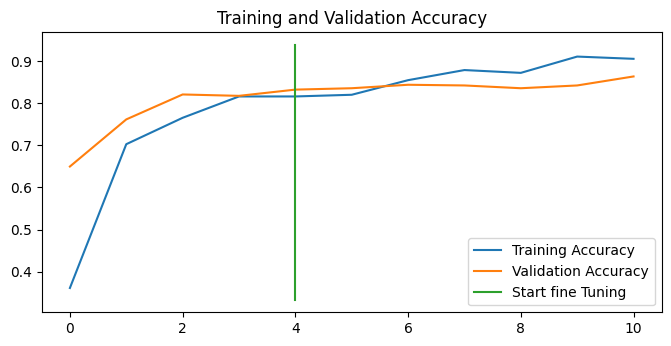

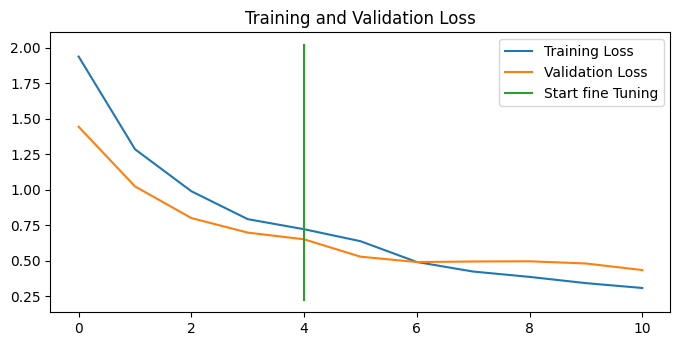

In [ ]:
compare_histories(history_2,
                  history_fine,
                  initial_epochs=5)

###Model 4:Fine-tuning an existing model on all of the data


In [ ]:
#Downlaod and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")


--2023-08-12 10:08:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 142.250.4.128, 172.253.118.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  23.6MB/s    in 23s     

2023-08-12 10:08:26 (21.9 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
#Set up training and test dir
train_dir_all_data="10_food_classes_all_data/train"
test_dir="10_food_classes_all_data/test"

In [ ]:
#How many images are we working with?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 

In [ ]:
#Setup data inputs
import tensorflow as tf
Img_size=(224,224)
train_data_all_classes=tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                           label_mode="categorical",
                                                                            image_size=Img_size)
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode="categorical",
                                                              image_size=Img_size)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous eperiments

Let's verify this

In [ ]:
#Evaulate model_2 (fine-tuned)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.4375 - accuracy: 0.8564


[0.4375433027744293, 0.8564000129699707]

To train a fine-tuning model we need to revert model_2 back to its feature extraction weights

Alright, the previous steps might seem quite confusing but all we've done is:

* Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint.
* Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
* Saved the results and training logs each time.
* Reloaded the model from 1 to do the same steps as 2 but with all of the data.
The same steps as 2?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [ ]:
#Check ehich layers are tunable in the whole model
for layer_number,layer in enumerate(model_2.layers):
  print(layer_number,layer.name,layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
#Let's drill into our base_model and see what layers are trainable
for layer_number,layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
#Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.001
                                                   ),
                metrics=["accuracy"])

In [ ]:
#Continue to train and fine-tune the model to our data (100%of training data)
fine_tune_epochs=initial_epochs+5

history_4=model_2.fit(train_data_all_classes,
                      epochs=fine_tune_epochs,
                      validation_data=test_data,
                      validation_steps=int(0.25*len(test_data)),
                      callbacks=[create_tensorboard_callback(dir_name="100%_data",
                                                             experiment_name="Fine_tuning_100_percent")])

Saving TensorBoard log files to: 100%_data/Fine_tuning_100_percent/20230812-100846


Epoch 1/10
235/235 [==============================] - 79s 293ms/step - loss: 0.6062 - accuracy: 0.8028 - val_loss: 0.2856 - val_accuracy: 0.9128
Epoch 2/10
235/235 [==============================] - 59s 248ms/step - loss: 0.4167 - accuracy: 0.8631 - val_loss: 0.2881 - val_accuracy: 0.8947
Epoch 3/10
235/235 [==============================] - 55s 232ms/step - loss: 0.3210 - accuracy: 0.8933 - val_loss: 0.2822 - val_accuracy: 0.9161
Epoch 4/10
235/235 [==============================] - 50s 212ms/step - loss: 0.2613 - accuracy: 0.9131 - val_loss: 0.3314 - val_accuracy: 0.8964
Epoch 5/10
235/235 [==============================] - 48s 201ms/step - loss: 0.2226 - accuracy: 0.9236 - val_loss: 0.2530 - val_accuracy: 0.9276
Epoch 6/10
235/235 [==============================] - 45s 186ms/step - loss: 0.1895 - accuracy: 0.9339 - val_loss: 0.3526 - val_accuracy: 0.8914
Epoch 7/10
235/235 [==============================] - 42s 177ms/step - loss: 0.1648 - accuracy: 0.9425 - val_loss: 0.2638 - val_ac

In [ ]:
#Lets evaluate on all of test data
results_4=model_2.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.2844 - accuracy: 0.9112


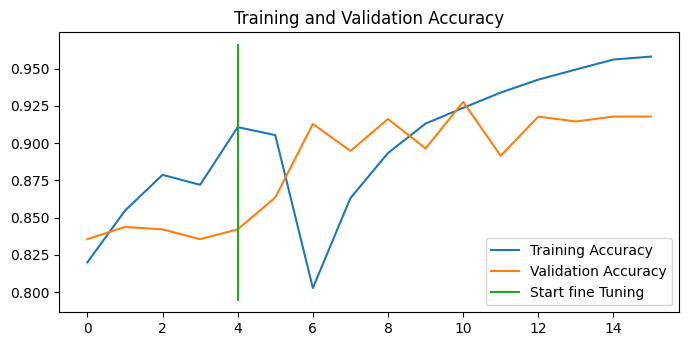

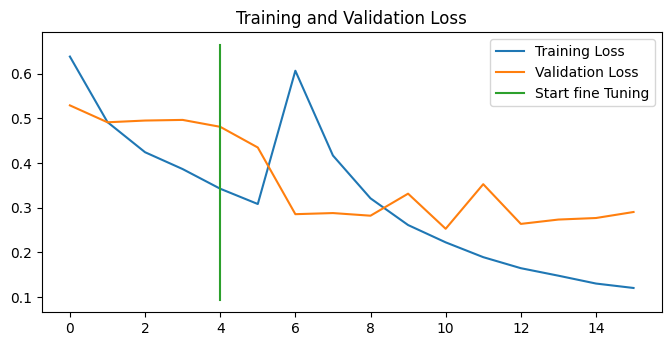

In [ ]:
#How did fine-tuning go with more data
compare_histories(history_fine,
                  history_4,
                  initial_epochs=5)

###Viewing our experiment data on TensorBoard

**Note**:Anything you upload to TensorBoard.dev is goint to be public. So if you have private data, do not upload.

In [ ]:
#View tensorboard logs of transfer learning modelling experiments
#upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning\
  --name "Transfer learning experiments with food 101"\
  --one_shot

2023-08-12 10:20:10.452856: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/YykpDd9WRfOJBIa68Qk11w/

[2023-08-12T10:20:12] Started scanning logdir.
[2023-08-12T10:20:18] Total uploaded: 126 scalars, 0 tensors, 4 binary objects (3.5 MB)
[2023-08-12T10:20:18] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/YykpDd9WRfOJBIa68Qk11w/


In [ ]:
#View all tensorboard dev list
!tensorboard dev list

2023-08-12 10:22:05.728562: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/YykpDd9WRfOJBIa68Qk11w/
	Name                 Transfer learning experiments with food 101
	Description          [No Description]
	Id                   YykpDd9WRfOJBIa68Qk11w
	Created              2023-08-12 10:20:12 (1 minute ago)
	Updated              2023-08-12 10:20:18 (1 minute ago)
	Runs                 8
	Tags                 5
	Scalars              126
	Tensor bytes         0
	Binary object bytes  3620364
https://tensorboard.dev/experiment/p0XoX6hmR5OM3Z6eWozmWA/
	Name                 Transfer learning experiments with food 101
	Description          [No Description]
	Id                   p0XoX6hmR5OM3Z6eWozmWA
	Created              2023-08-12 10:19:19 (2 minutes ago)
	Updated              2023-08-12 10:19:26 (2 minutes ago)
	Runs                 8
	Tags                 5
	Scalars              126
	Tensor bytes         0
	B

In [ ]:
#To delete an experiment
#!tensorboard dev delete --experiment_id YykpDd9WRfOJBIa68Qk11w